# Starting notebook

Let us visualize the data and produce low pass filtering

In [1]:
# Some useful modules for notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdne.conf import Config
import h5py
from scipy import signal
import numpy as np
from tqdm import tqdm

from tqdne.dataset import compute_mean_std_features, extract_sample_from_h5file, build_dataset

In [4]:
config = Config()

In [5]:
config.datasetdir

PosixPath('/store/sdsc/sd28')

In [6]:
import os
print(os.environ.get("DATASETDIR"))

None


In [10]:
datapath = config.datapath
features_keys = config.features_keys
means, stds = compute_mean_std_features(datapath, features_keys)
features_keys, means, stds

(('hypocentral_distance',
  'is_shallow_crustal',
  'log10snr',
  'magnitude',
  'vs30'),
 array([1.14903990e+02, 2.44950564e-01, 2.95203499e+00, 5.09356751e+00,
        3.31229437e+02]),
 array([ 37.53284703,   0.43005789,   1.90142173,   0.52926114,
        220.90386893]))

Key: hypocentral_distance -- shape:(1, 212598)
Key: hypocentre_depth -- shape:(1, 212598)
Key: hypocentre_latitude -- shape:(1, 212598)
Key: hypocentre_longitude -- shape:(1, 212598)
Key: is_shallow_crustal -- shape:(1, 212598)
Key: log10snr -- shape:(1, 212598)
Key: magnitude -- shape:(1, 212598)
Key: time_vector -- shape:(5501,)
Key: vs30 -- shape:(1, 212598)
Key: waveforms -- shape:(3, 5501, 212598)


array([106.98774861,   1.        ,   5.40055698,   4.5       ,
       300.        ])

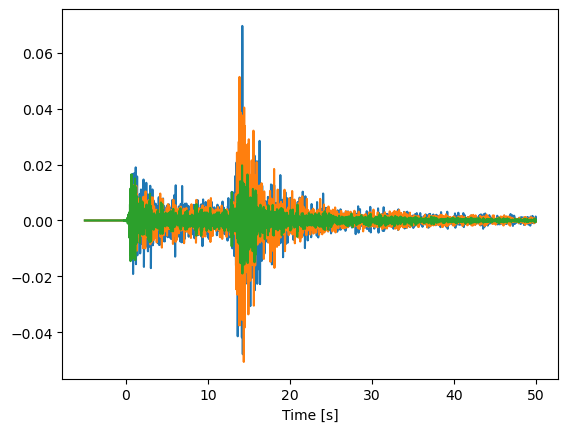

In [18]:
# Opent the hdf5 file

sample_id = 10
with h5py.File(datapath, "r") as f:
    for key in f.keys():
        print(f"Key: {key} -- shape:{f[key].shape}")

    time = f["time_vector"][:]
    waveform, features = extract_sample_from_h5file(f, sample_id)
plt.plot(time, waveform.T)
plt.xlabel("Time [s]")
features

In [19]:
fs = config.fs # sampling frequency
params_filter = config.params_filter # filter parameters
fs, params_filter

(100, {'N': 2, 'Wn': 1, 'btype': 'lp'})

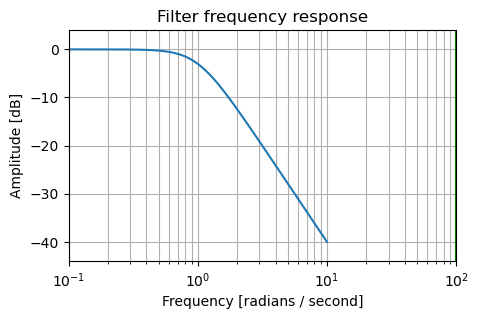

In [20]:
# plot the frequency response
b, a = signal.butter(**params_filter, analog=True)
w, h = signal.freqs(b, a)
plt.figure(figsize=(5,3))
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

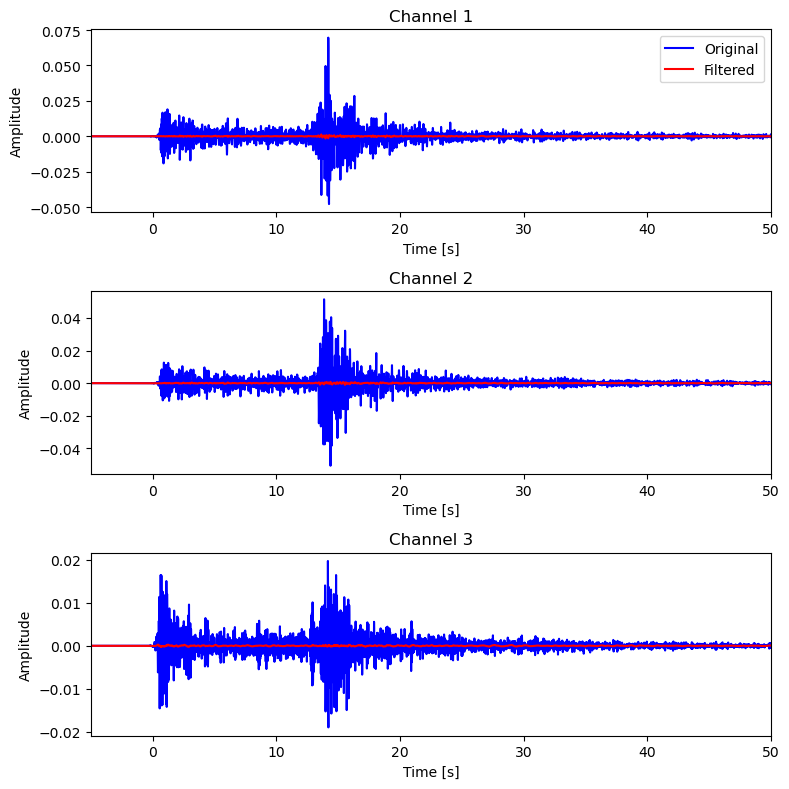

In [21]:
sos = signal.butter(**params_filter, fs=fs, output='sos')
datafilt = []
plt.figure(figsize=(8, 8))
for i, channel in enumerate(waveform):
    channel_filt = signal.sosfilt(sos, channel)
    datafilt.append(channel_filt)
    plt.subplot(len(waveform), 1, 1+i)
    plt.plot(time, channel , 'b',  alpha=1,)
    plt.plot(time, channel_filt,  'r', alpha=1,)
    plt.title(f"Channel {i+1}")
    plt.xlim(np.min(time), np.max(time))
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    if i == 0:
        plt.legend(["Original","Filtered"])
    # plt.xlim(8, 12)
plt.tight_layout()


array([-0.21091504,  1.75569257,  1.2877322 , -1.12150216, -0.14137116])

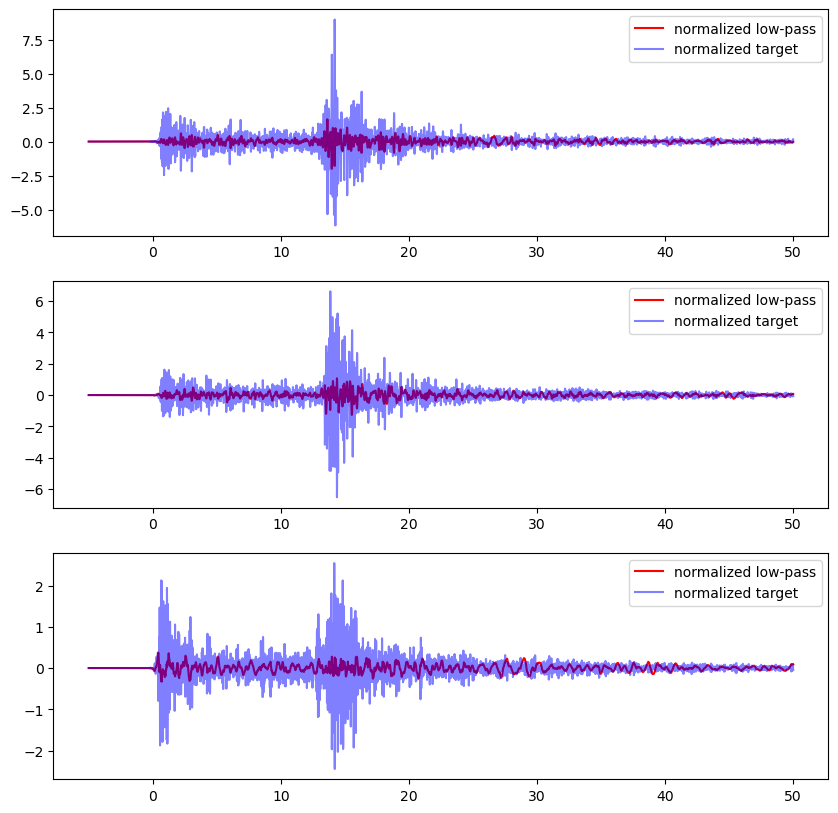

In [22]:

sigma_in = config.sigma_in
datafilt = np.array(datafilt)


# Normalize the waveform with respect of the datafilt
scale = np.abs(datafilt).max() 
datafilt = datafilt / scale * 2
waveform = waveform / scale / 5

# normalize the features
features = (features - means) / stds    

n_channels = waveform.shape[0]
plt.figure(figsize=(10, 10))
for i, (filt, orig) in enumerate(zip(datafilt, waveform)):
    plt.subplot(n_channels, 1, 1+i)
    plt.plot(time, filt,  'r', alpha=1, label="normalized low-pass")
    plt.plot(time, orig , 'b',  alpha=0.5, label="normalized target")
    plt.legend()
    # plt.xlim(8, 12
features